In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

In [2]:
df = pd.read_csv('./data/data_entry.csv')
df = df.dropna(\
    subset=['Image Index', 'Finding Labels', 'Patient ID', 'Patient Age', 'Patient Gender']\
) # drop rows with null values in these columns -- with current column subset, no values are dropped (:

# since there are ridiculous ages ranging from 148 to 414, filter the ones that are obviously wrong
df = df[df['Patient Age'] <= 90]

print
print('*'*40 + ' General Info ' + '*'*40)
print

num_images = df.shape[0]
ages = sorted(df['Patient Age'].unique()) 
ids = sorted(df['Patient ID'].unique())
genders = ['M', 'F']
labels = sorted(df['Finding Labels'].unique())
num_with_multiple_labels = df[df['Finding Labels'].str.contains('\|')].shape[0]

print('{} total images'.format(num_images))
print('{} unique patients'.format(len(ids)))
print('{} unique ages'.format(len(ages)))
print('{} unique labels'.format(len(labels)))
print('{0:.0%} images are annotated with multiple labels'.format(num_with_multiple_labels / float(num_images)))

print
print('*'*(80 + len(' General Info ')) + '\n')
print
pass

**************************************** General Info ****************************************
112069 total images
30793 unique patients
90 unique ages
836 unique labels
19% images are annotated with multiple labels
**********************************************************************************************



In [5]:
# displays 3 histograms to visualize demographic info
def show_demographic_distributions(df, split_name='total'):
    # split_name should be train, val, test. empty means df represents entire set

    # get male/female
    male_df = df[df['Patient Gender'] == 'M']
    female_df = df[df['Patient Gender'] == 'F']
    
    # Figure 1 displays age/sex distribution of IMAGES (note that this isn't the same as number of patients)
    num_bars = len(ages)
    male_counts = [male_df[male_df['Patient Age'] == column_val].shape[0] for column_val in ages]
    female_counts = [female_df[female_df['Patient Age'] == column_val].shape[0] for column_val in ages]
    x_bar_indices = np.arange(num_bars)   # the x locations for the groups

    plt.figure(figsize=(18, 8))
    p1 = plt.bar(x_bar_indices, male_counts)
    p2 = plt.bar(x_bar_indices, female_counts, bottom=male_counts)

    plt.xlabel('Age')
    plt.ylabel('Number of Images')
    plt.title('Number of Images by Age and Sex')
    max_y = max(male_counts) + max(female_counts)
    plt.yticks(np.arange(0, max_y + 250, 500))
    plt.legend((p1[0], p2[0]), ('Men', 'Women'))

    plt.savefig('figs/{}_num_images_by_sex_and_age.png'.format(split_name))
    plt.show()

    # Figure 2 displays health/sex distribution of IMAGES (note that this isn't the same as number of patients)
    values = [False, True]
    num_bars = 2
    male_counts = [male_df[male_df['Healthy'] == column_val].shape[0] for column_val in values]
    female_counts = [female_df[female_df['Healthy'] == column_val].shape[0] for column_val in values]
    x_bar_indices = np.arange(num_bars)   # the x locations for the groups

    plt.figure(figsize=(6, 8))
    p1 = plt.bar(x_bar_indices, male_counts)
    p2 = plt.bar(x_bar_indices, female_counts, bottom=male_counts)

    plt.ylabel('Number of Images')
    plt.title('Number of Images by Sex and X-Ray Health Status')
    plt.xticks(x_bar_indices, ['Unhealthy', 'Healthy'])
    max_y = max(male_counts) + max(female_counts)
    plt.yticks(np.arange(0, max_y + 250, 10000))
    plt.legend((p1[0], p2[0]), ('Men', 'Women'))

    plt.savefig('figs/{}_num_images_by_sex_and_health.png'.format(split_name))
    plt.show()
    
    # Figure 3 displays age/health distribution of IMAGES (note that this isn't the same as number of patients)
    num_bars = len(ages)
    healthy_counts = [df[df['Healthy'] & (df['Patient Age'] == age)].shape[0] for age in ages]
    unhealthy_counts = [df[~df['Healthy'] & (df['Patient Age'] == age)].shape[0] for age in ages]
    x_bar_indices = np.arange(num_bars)   # the x locations for the groups

    plt.figure(figsize=(18, 8))
    p1 = plt.bar(x_bar_indices, healthy_counts)
    p2 = plt.bar(x_bar_indices, unhealthy_counts, bottom=healthy_counts)

    plt.xlabel('Age')
    plt.ylabel('Number of Images')
    plt.title('Number of Images by Age and Health')
    max_y = max(healthy_counts) + max(unhealthy_counts)
    plt.yticks(np.arange(0, max_y + 250, 500))
    plt.legend((p1[0], p2[0]), ('Healthy', 'Unhealthy'))

    plt.savefig('figs/{}_num_images_by_age_and_health.png'.format(split_name))
    plt.show()

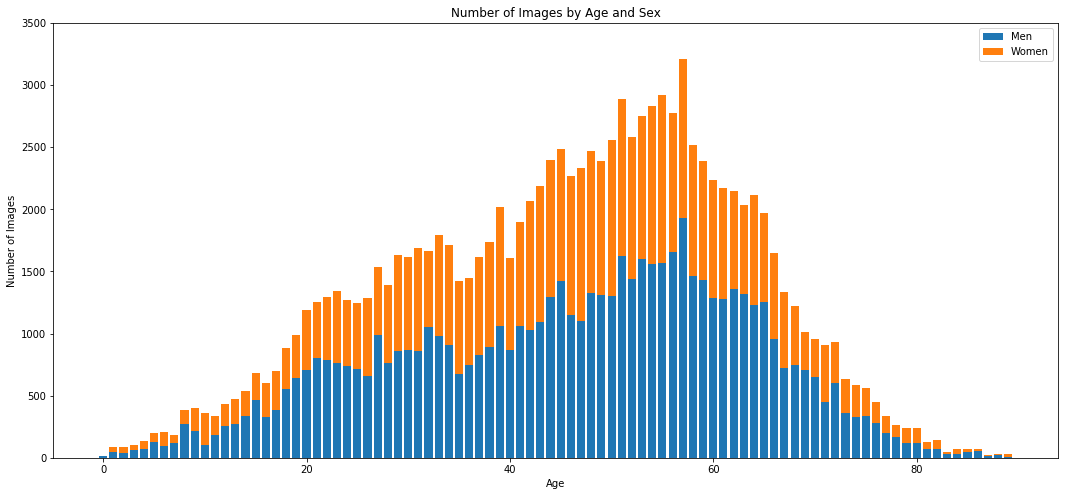

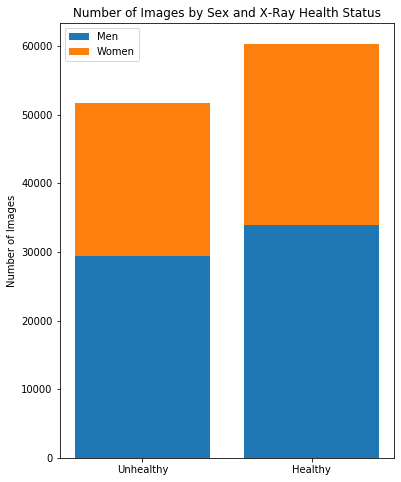

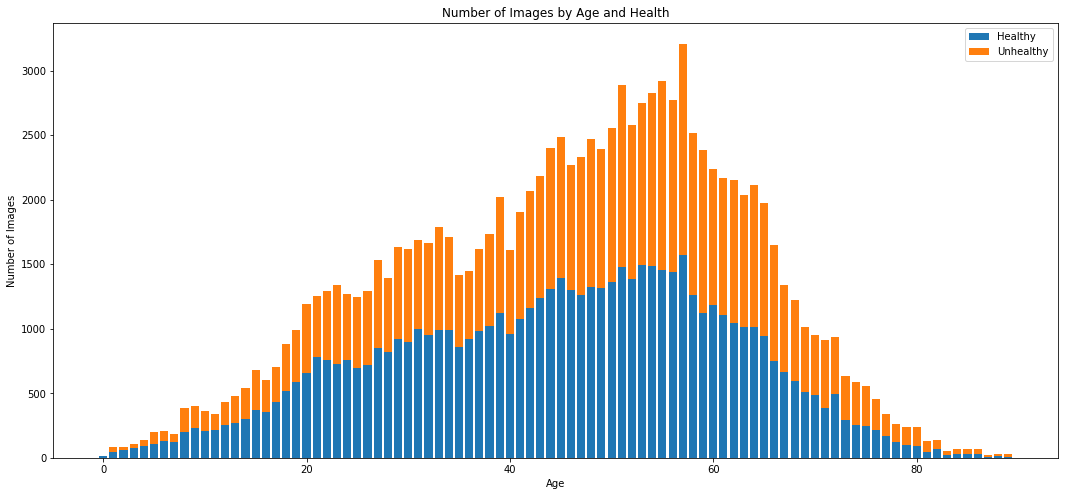

In [6]:
# visualize demo distribution over entire dataset
show_demographic_distributions(df)

In [7]:
df.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Healthy
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,False
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,False
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,False
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,True
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,False


In [6]:



### don't run this again --- will change our train/val/test splits


### if we need to fetch the train/val/test data, I can write another script to 
### do that






# construct label dict { image_id -> binary label }
# labels = { image_id: healthy for image_id, healthy in zip(df['Image Index'].values, df['Healthy'].values) }

# later these are saved to disk and will be used in the model
# train_df = pd.DataFrame()
# val_df = pd.DataFrame()
# test_df = pd.DataFrame()
# for sex in ['M', 'F']:
#     sex_df = df[df['Patient Gender'] == sex]
#     for age in ages:
        
#         demographic_df = sex_df[sex_df['Patient Age'] == age]
        
#         # apply sklearn train_test_split twice to achieve a 3-way split
#         # note that this is a 60-20-20 split
#         demo_train_df, demo_test_df = train_test_split(demographic_df, train_size=0.8)
#         demo_train_df, demo_val_df = train_test_split(demo_train_df, train_size=0.75)
        
#         train_df = pd.concat([train_df, demo_train_df])
#         val_df = pd.concat([val_df, demo_val_df])
#         test_df = pd.concat([test_df, demo_test_df])
        
# train_ids = list(train_df['Image Index'].values)
# val_ids = list(val_df['Image Index'].values)
# test_ids = list(test_df['Image Index'].values)
        
# print('Final train, val, test split counts: \t {} \t {} \t {} \t'.format(len(train_ids), len(val_ids), len(test_ids)))

# # ensure we didn't lose any labels or images
# num_labels = len(labels.keys())
# num_image_ids = len(train_ids) + len(val_ids) + len(test_ids)
# assert num_labels == num_image_ids


Final train, val, test split counts: 	 67137 	 22446 	 22486 	


In [7]:

### don't run this again --- will change our train/val/test splits



# write lists to files for model to use
# for split, ids in zip(['train', 'val', 'test'], [train_ids, val_ids, test_ids]):
#     with open('data/{}_image_ids.data'.format(split), 'wb') as filehandle:
#         # store the data as binary data stream
#         pickle.dump(ids, filehandle)
        
# # need to use 0/1 instead of boolean
# labels = { key: 1 if val else 0 for key, val in labels.items() }
# with open('data/labels.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(labels, filehandle)

In [12]:
# this cell loads train/val/test dataframes in the dfs object below by
# reading the ids from disk and extracting the corresponding rows

dfs = {}
for split in ['train', 'val', 'test']:
    with open('data/{}_image_ids.data'.format(split), 'rb') as filehandle:
        # store the data as binary data stream
        ids = pickle.load(filehandle)
        mask = df['Image Index'].isin(ids)
        dfs[split] = df[mask]
        

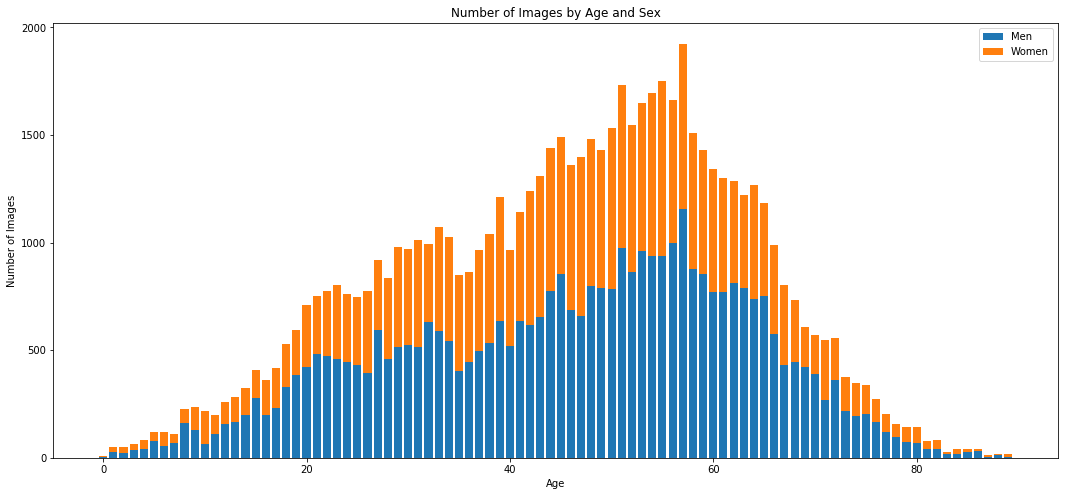

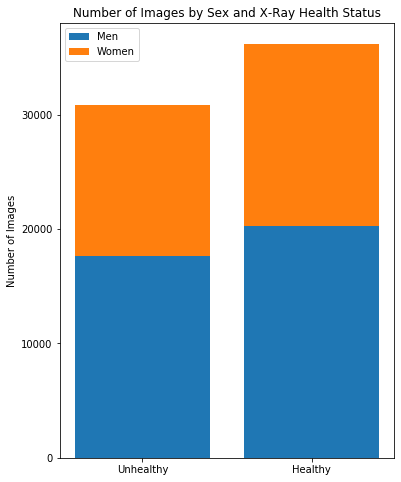

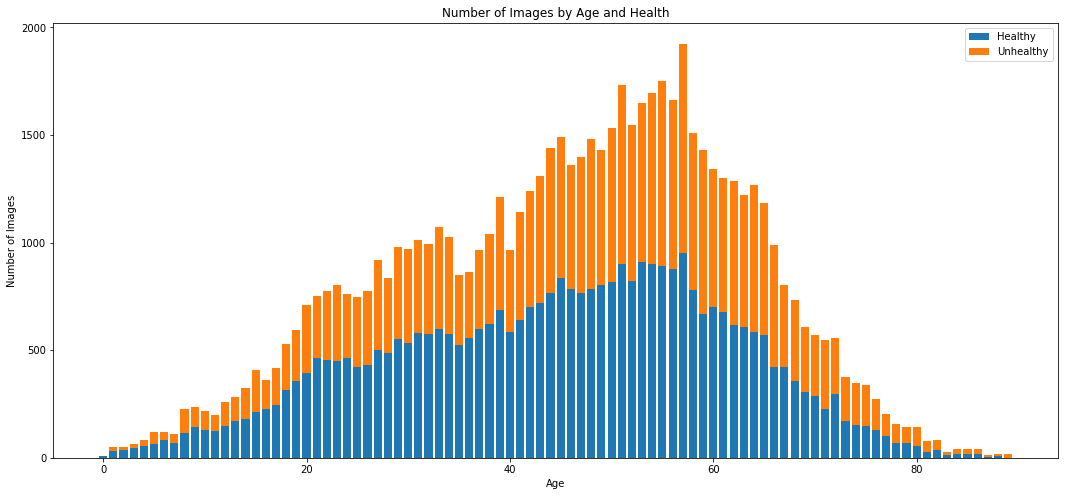

In [9]:
show_demographic_distributions(dfs['train'], 'train')

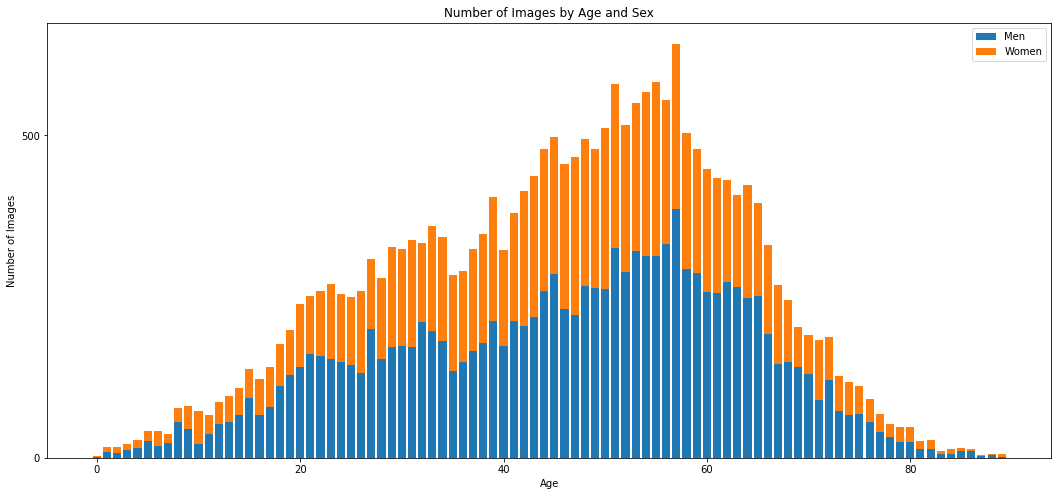

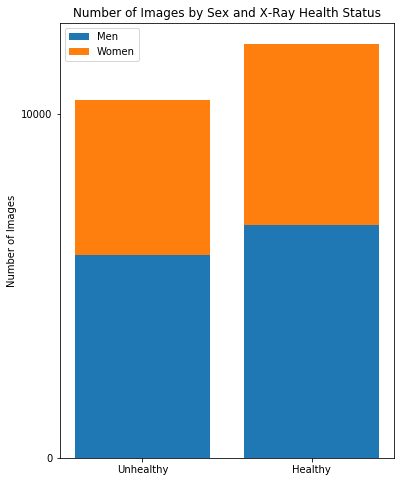

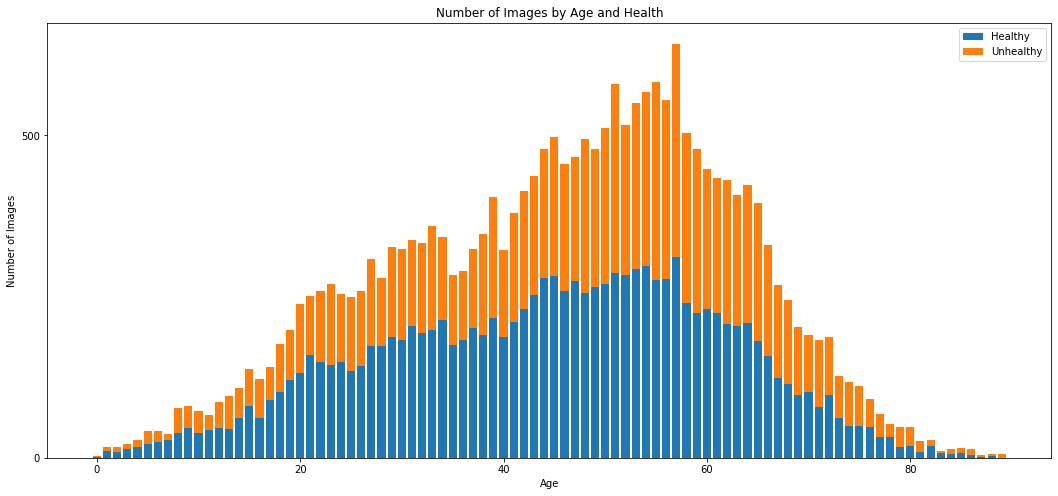

In [10]:
show_demographic_distributions(dfs['val'], 'val')

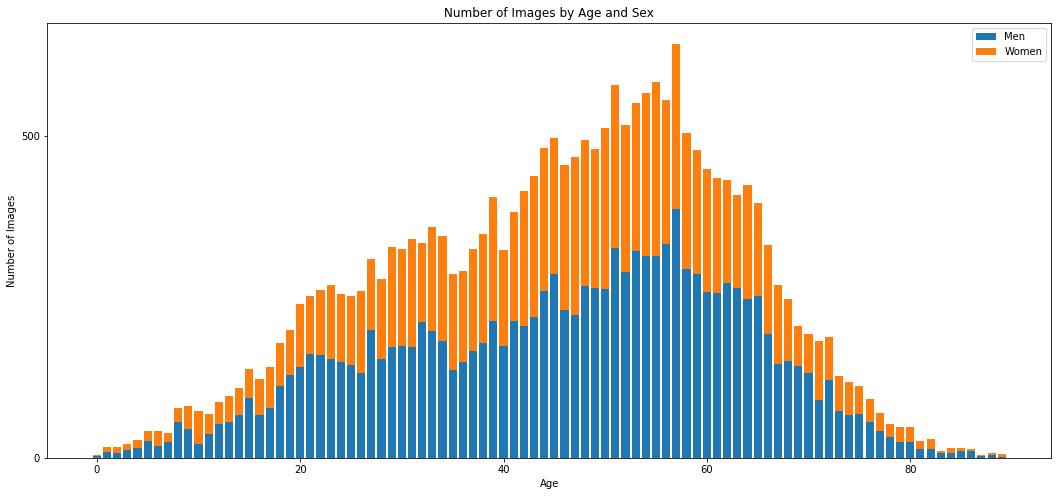

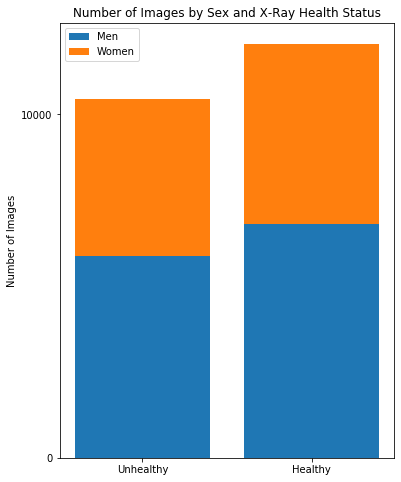

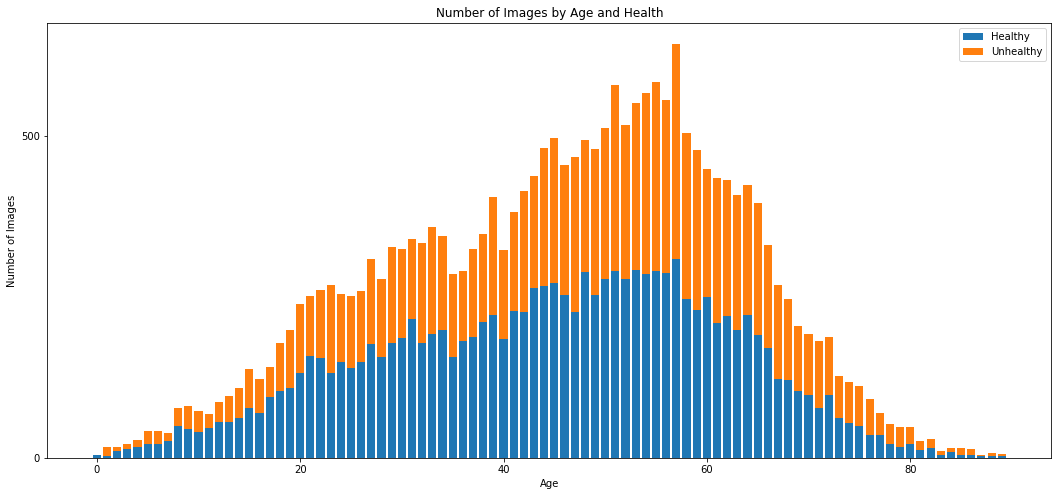

In [11]:
show_demographic_distributions(dfs['test'], 'test')